<div style="float:left;"><img src="logo.png" width="500"/></div>

# Visualising Networks

In this demo, we will work with both visual and non-visual representations of networks, in the context of public healthcare data and contact tracing. This will include working with the [Gephi](https://gephi.org/) network visualisation tool.

We will use a modified version of a dataset which was collected in a hospital ward in France in 2010. The data records contacts between patients and health-care workers in the ward over several days, where wearable sensors were used to detect close-range interactions.

In [1]:
from pathlib import Path
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline
# display settings
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'sans-serif'
role_colors = {"patient":"#d982d0", "doctor":"#52c852", "nurse":"#7cd1f5", "student":"#f77860", "admin":"#359371"}

## Data Loading

We will primarily focus on the first day of the monitoring period. First we will load the metadata, describing the paricipants in the hospital at this time.

In [2]:
meta_path = Path("../Data") / "tracing-metadata-day1.csv"
df_metadata = pd.read_csv(meta_path, index_col=0)
df_metadata.head(10)

,name,role
participant_id,,
1098,Jimmy Reilly,admin
1100,Sandra Hallam,doctor
1108,Len Moers,doctor
1109,Timothy Bonner,doctor
1114,Melody Norwood,doctor
1115,Amparo Smith,doctor
1116,Karyn Stone,doctor
1130,Robert Roberts,nurse
1142,Jim Mcafee,doctor


Every participant has some metadata associated with them, most interestingly their "role" (e.g. doctor, patient etc).

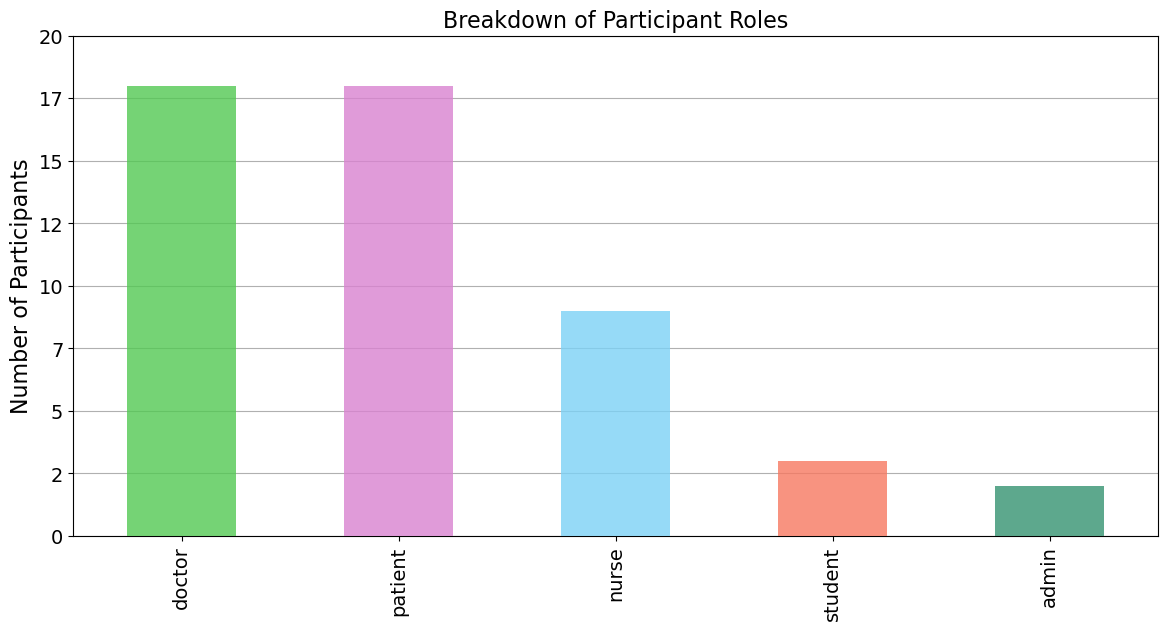

In [3]:
counts = df_metadata["role"].value_counts()
colors = [ role_colors[role] for role in counts.index ]
ax = counts.plot( kind="bar", fontsize=14, figsize=(14,6.5), color=colors, alpha=0.8, zorder=3)
ax.set_title("Breakdown of Participant Roles", fontsize=16)
ax.set_ylabel("Number of Participants", fontsize=16)
ax.set_ylim(0,20)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
ax.yaxis.grid();

Next, we will load the contact data for this time period. This describes all instances where two participants were in close proximity (i.e. had contact).

In [4]:
in_path = Path("../Data") / "tracing-contacts-day1.csv"
df_contacts = pd.read_csv(in_path)
df_contacts["date"] = pd.to_datetime(df_contacts["date"])
df_contacts.head( 5 )

,date,participant1,participant2
0,2010-12-07 00:01:18.480,1246,1378
1,2010-12-07 00:02:39.000,1246,1378
2,2010-12-07 00:12:02.640,1238,1246
3,2010-12-07 00:17:24.720,1246,1378
4,2010-12-07 00:24:07.320,1238,1246


In [5]:
print("%d total contacts between %d participants" % ( len(df_contacts), len(df_metadata) ) )

4967 total contacts between 50 participants


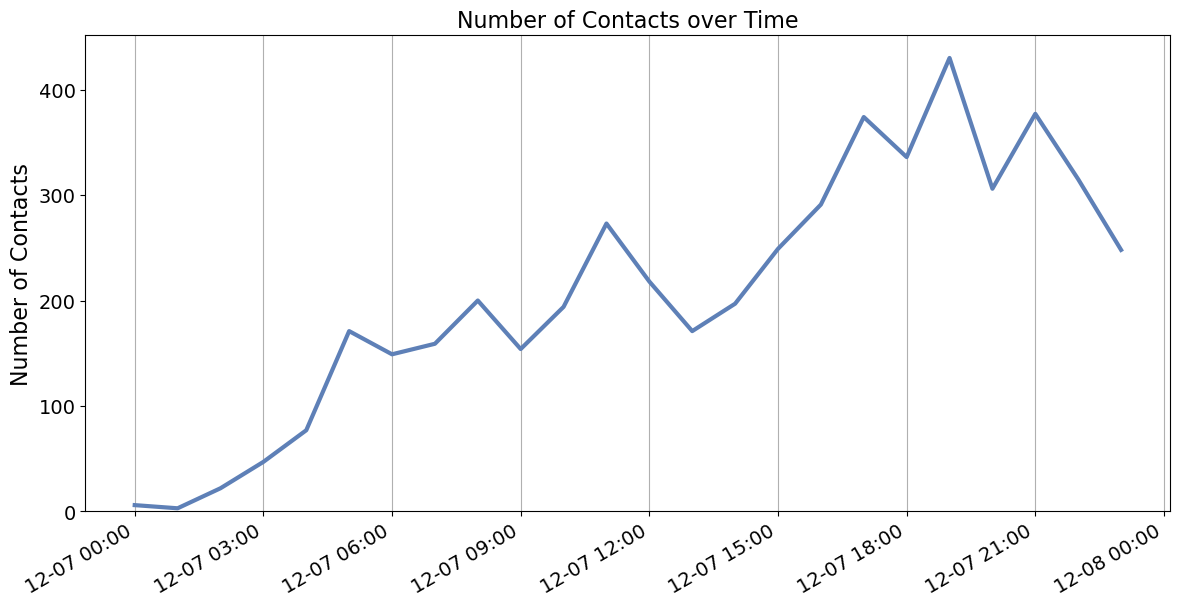

In [6]:
df_hours = df_contacts["date"].dt.floor('h')
df_hour_counts = df_hours.value_counts()
ax = df_hour_counts.plot(figsize=(14,7), fontsize=14, color="#5e80b7", linewidth=3, zorder=3)
ax.set_title("Number of Contacts over Time", fontsize=16);
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
ax.set_ylim(0)
ax.set_ylabel("Number of Contacts", fontsize=16)
ax.xaxis.grid();

## Network Creation

Now we will create a **contact network** between all of the participants for this day. 

In this type of network, each **node** will represent a participant who was involved in a contact (either a partient or health-care worker). We will create an **edge** between two nodes (i.e. participants) if they were in contact at least once.

Each edge will have a **weight**, indicating the frequency of contact between two participants. A higher weight means that two participants were more frequently in contact with one another over the day.

<div style="float:left; margin-left: 3em; margin-top: 0;">
<img src="example_contacts.png" width="800"/>
</div>

First, create a new network and add the nodes. Each node can have **attributes** associated with it (e.g. role and name).

In [7]:
g = nx.Graph()

In [8]:
for node_id, row in df_metadata.iterrows():
    g.add_node(node_id, name=row["name"], role=row["role"])
print("Network has %d nodes" % g.number_of_nodes())

Network has 50 nodes


Next, we add the edges. To get the frequencies, we need to add up the counts for all pairs of participants who had contact with each other.

In [9]:
from collections import Counter
frequencies = Counter()
for i, row in df_contacts.iterrows():
    pair = frozenset([row["participant1"], row["participant2"]])
    frequencies[pair] += 1

In [10]:
for pair in frequencies:
    nodes = list(pair)
    g.add_edge(nodes[0], nodes[1], weight=frequencies[pair])
print("Network has %d edges" % g.number_of_edges())

Network has 355 edges


## Network Analysis

Next we will look at characterising various aspects of the network, to get a better insight into how contacts are occurring within the hospital ward.

First, we can confirm that the network is a single **component** - i.e. everyone is connected directly or indirectly:

In [11]:
nx.number_connected_components(g)

1

In network analysis, we often talk about "six degrees of separation". 

For the contact network, we can check its **diameter** - what is the maximum number of "hops" from one person to another.

In [12]:
print("Diameter = %d" % nx.diameter(g))

Diameter = 4


The diameter represents the furthest case. What is the average number of hops between two people in the ward?

In [13]:
print("Average path length between 2 nodes = %.1f" % nx.average_shortest_path_length(g))

Average path length between 2 nodes = 1.9


Next, we will look a centrality. For a contact network, the most popular measure, **degree centrality**, indicates the number of **unique contacts** each 

In [14]:
degrees = pd.Series(dict(g.degree()))

We could plot a histogram to give us an overall picture of the contact network:

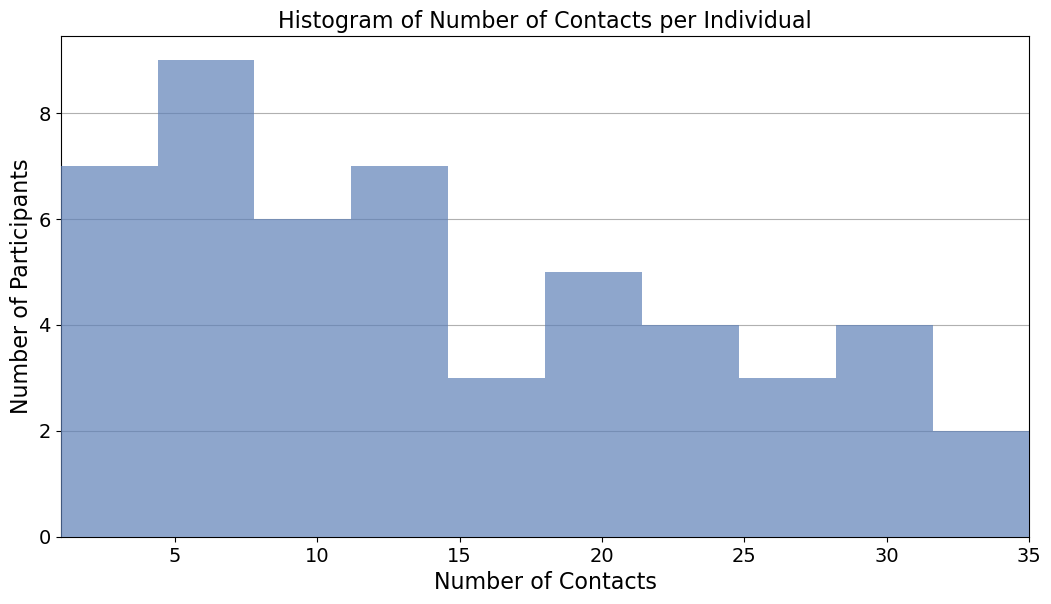

In [15]:
ax = degrees.hist(figsize=(12.5,6.5), color="#5e80b7", alpha=0.7, zorder=3)
ax.set_ylim(0)
ax.set_xlim(1, 35)
ax.set_title("Histogram of Number of Contacts per Individual", fontsize=16);
ax.set_ylabel("Number of Participants", fontsize=16)
ax.set_xlabel("Number of Contacts", fontsize=16);
ax.tick_params(axis='both', which='major', labelsize=14);
ax.xaxis.grid(False)
ax.yaxis.grid(True)

We could also look at which individuals have the highest number of **unique** contacts:

In [16]:
top = 15
top_degrees = degrees.sort_values(ascending=False).head(top)
rows = {}
colors = []
for i, degree in top_degrees.iteritems():
    participant_meta = df_metadata.loc[i]
    label = "%s (%s)" % ( participant_meta["name"], participant_meta["role"] )
    rows[label] = degree
    colors.append(role_colors[participant_meta["role"]])
labelled_degrees = pd.Series(rows)

/tmp/ipykernel_12162/1471948649.py:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, degree in top_degrees.iteritems():


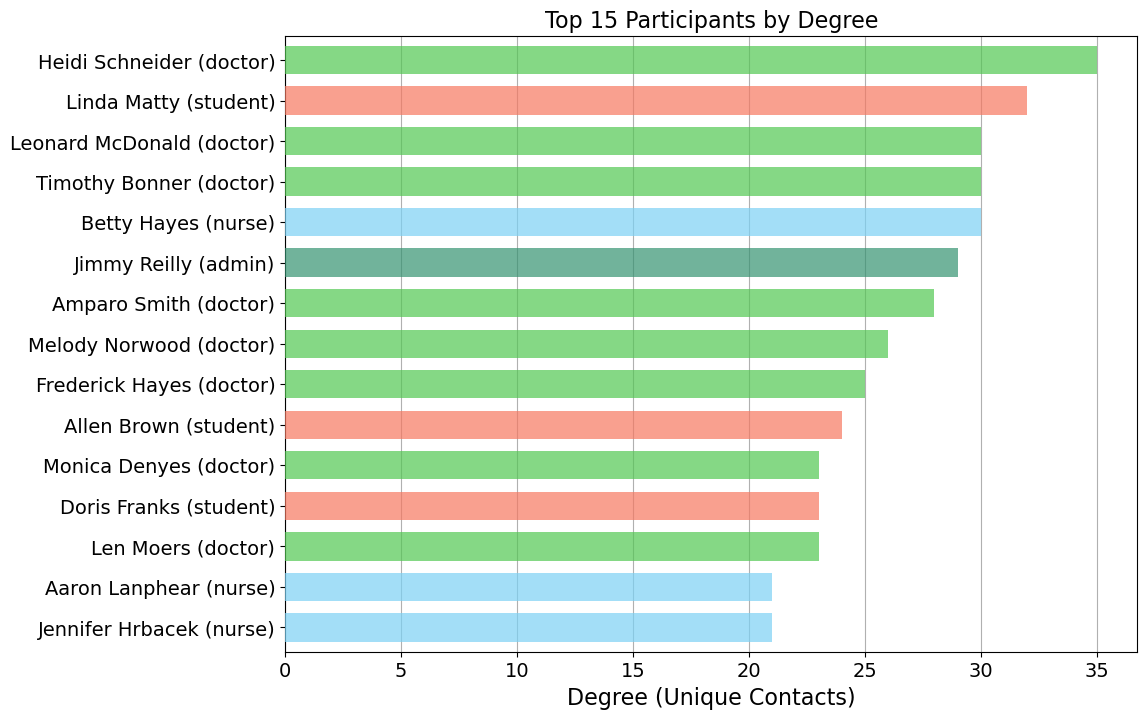

In [17]:
# note we need to reverse the order of values for the bar plot to display correctly
ax = labelled_degrees[::-1].plot(kind="barh", figsize=(11,8), fontsize=14, color=colors[::-1], alpha=0.7, 
                                 width=0.7, zorder=3)
ax.set_title("Top %d Participants by Degree" % top, fontsize=16);
ax.set_xlabel("Degree (Unique Contacts)", fontsize=16)
ax.xaxis.grid()

We can also take into account the **weight** on each edge. That is, the frequency of interaction between each pair.

Firstly, we can look at the most frequently interacting pairs.

In [18]:
df_edges = nx.to_pandas_edgelist(g)
df_top_edges = df_edges.sort_values(by="weight", ascending=False).head(10)
rows = []
for i, row in df_top_edges.iterrows():
    participant_meta1 = df_metadata.loc[row["source"]]
    participant_meta2 = df_metadata.loc[row["target"]]  
    label1 = "%s (%s)" % ( participant_meta1["name"], participant_meta1["role"] )
    label2 = "%s (%s)" % ( participant_meta2["name"], participant_meta2["role"] )
    rows.append( { "participant1" : label1, "participant2" : label2, "frequency" : row["weight"] } )
pd.DataFrame( rows )

,participant1,participant2,frequency
0,Doris Franks (student),Linda Matty (student),364
1,Melody Norwood (doctor),Frederick Hayes (doctor),344
2,Linda Matty (student),Allen Brown (student),195
3,Amparo Smith (doctor),Heidi Schneider (doctor),186
4,Jennifer Hrbacek (nurse),Betty Hayes (nurse),151
5,Aaron Lanphear (nurse),Teresa Suarez (nurse),151
6,Leonard McDonald (doctor),Heidi Schneider (doctor),143
7,Timothy Bonner (doctor),Amparo Smith (doctor),122
8,Timothy Bonner (doctor),Heidi Schneider (doctor),120
9,Doris Franks (student),Allen Brown (student),119


We could also look at which individuals have the most frequent contacts - i.e. the highest weighted degree:

In [19]:
# calculate the weighted degree scores
wdegrees = pd.Series(dict(g.degree(weight="weight")))

In [20]:
# sort the values
top = 15
top_wdegrees = wdegrees.sort_values(ascending=False).head(top)
# generate a new version of the series
rows = {}
colors = []
for i, wdegree in top_wdegrees.iteritems():
    participant_meta = df_metadata.loc[i]
    label = "%s (%s)" % ( participant_meta["name"], participant_meta["role"] )
    rows[label] = wdegree
    colors.append( role_colors[participant_meta["role"]] )
labelled_wdegrees = pd.Series(rows)

/tmp/ipykernel_12162/3219104438.py:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, wdegree in top_wdegrees.iteritems():


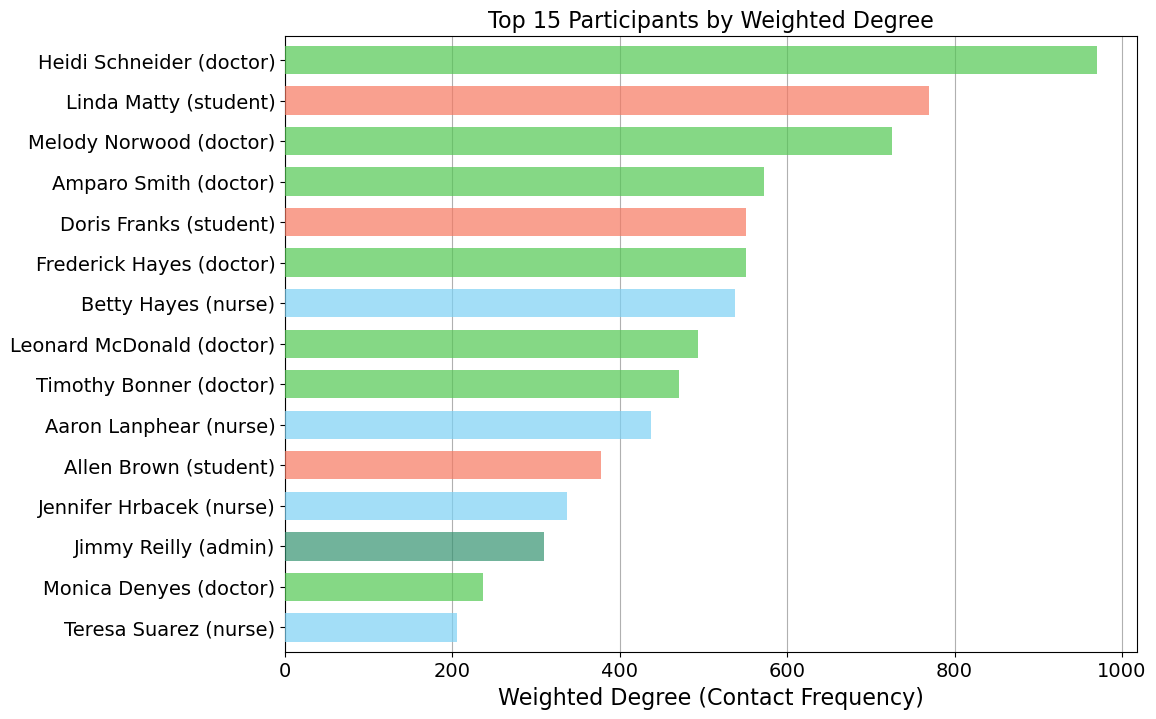

In [21]:
# plot as a horizontal bar chart
ax = labelled_wdegrees[::-1].plot(kind="barh", figsize=(11,8), fontsize=14, color=colors[::-1], alpha=0.7,
                                  width=0.7, zorder=3)
ax.set_title("Top %d Participants by Weighted Degree" % top, fontsize=16);
ax.set_xlabel("Weighted Degree (Contact Frequency)", fontsize=16)
ax.xaxis.grid()

## Ego Networks

We could decide to focus on a particular region of the network. One way to do this is to create one or more **ego networks**. An ego network is a subgraph which consists of a focal node (the ego) and the nodes to whom ego is directly connected (the alters), plus the edges among the alters. In the case of our contact network, this represents a participant and their close contacts.

In [22]:
ego_node = 1399
eg = nx.ego_graph(g, ego_node)
# how many nodes and edges are in the ego network?
print("Ego network for node %s has %d nodes and %d edges" 
      % (ego_node, eg.number_of_nodes(), eg.number_of_edges()))

Ego network for node 1399 has 7 nodes and 20 edges


We can visualise these smaller subgraphs easily using NetworkX:

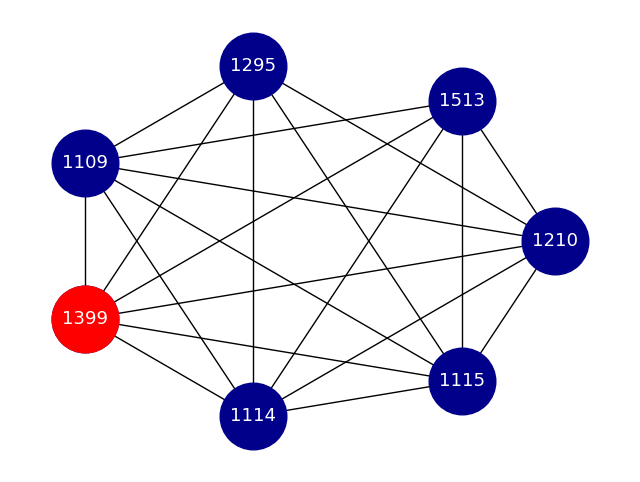

In [23]:
# draw the ego network
plt.figure(figsize=(8,6))
plt.margins(0.1, 0.1)
pos = nx.circular_layout(eg)
nx.draw(eg, pos=pos, with_labels=True, node_color='darkblue', node_size=2300, font_color='white', font_size=13)
# add the ego node in a different colour
nx.draw_networkx_nodes(eg, pos, nodelist=[ego_node], node_size=2300, node_color="red");

## Visualising Networks

NetworkX is not primarily designed for visualisation. If we want to visualise and explore the contact network in more detail, we can export it in GEXF format and load it into a dedicated visualisation tool such as [Gephi](https://gephi.org/).

In [24]:
# explore the network for the original first day network
nx.write_gexf(g, "contacts-day1.gexf")